# Predicting Player Market Value with Linear Regression

## 1. Load the Dataset

In [240]:
import pandas as pd

df = pd.read_csv('player_data_final.csv')
# df = pd.read_csv('player_market_value_data.csv')
df.head()

,player_id,market_value_in_eur,position,foot,height_in_cm,age,total_goals,total_assists,total_minutes_played
0,10,1000000.0,4,0,184.0,38,48.0,25.0,8808.0
1,26,750000.0,1,1,190.0,38,0.0,0.0,13508.0
2,65,1000000.0,4,3,183.0,35,38.0,13.0,8788.0
3,77,200000.0,2,3,183.0,34,0.0,0.0,307.0
4,80,100000.0,1,0,194.0,36,0.0,0.0,1080.0


## 2. Data Preprocessing

In [241]:
# Handle categorical variables using one-hot encoding
df_processed = pd.get_dummies(df, columns=['position', 'foot'])

# Display the first few rows of the processed dataframe
df_processed.head()

,player_id,market_value_in_eur,height_in_cm,age,total_goals,total_assists,total_minutes_played,position_0,position_1,position_2,position_3,position_4,foot_0,foot_1,foot_2,foot_3
0,10,1000000.0,184.0,38,48.0,25.0,8808.0,False,False,False,False,True,True,False,False,False
1,26,750000.0,190.0,38,0.0,0.0,13508.0,False,True,False,False,False,False,True,False,False
2,65,1000000.0,183.0,35,38.0,13.0,8788.0,False,False,False,False,True,False,False,False,True
3,77,200000.0,183.0,34,0.0,0.0,307.0,False,False,True,False,False,False,False,False,True
4,80,100000.0,194.0,36,0.0,0.0,1080.0,False,True,False,False,False,True,False,False,False


## 3. Define Features (X) and Target (y)

In [242]:
X = df_processed.drop(['player_id', 'market_value_in_eur'], axis=1)
y = df_processed['market_value_in_eur']

In [295]:
# --- Check for Multicollinearity ---

 # Calculate the correlation matrix for your features
correlation_matrix = X.corr().abs()
    
 # Unstack the matrix to create a list of all pairs
correlation_pairs = correlation_matrix.unstack()

 # Sort the pairs by their correlation value
sorted_pairs = correlation_pairs.sort_values(kind="quicksort", ascending=False)

 # Filter to find pairs with high correlation (e.g., > 0.7)
 # We also remove self-correlations (where the value is 1.0)
highly_correlated = sorted_pairs[(sorted_pairs > 0.7) & (sorted_pairs < 1)]

print("Highly correlated feature pairs (absolute value > 0.7):")
print(highly_correlated)

Highly correlated feature pairs (absolute value > 0.7):
total_assists         total_goals             0.789484
total_goals           total_assists           0.789484
foot_1                foot_0                  0.770283
foot_0                foot_1                  0.770283
total_minutes_played  total_assists           0.706316
total_assists         total_minutes_played    0.706316
dtype: float64


In [ ]:
import numpy as np

X.shape
indices = np.arange(X.shape[0])
np.random.shuffle(indices)

# Step 2: Calculate split index (e.g., 80% train)

split_ratio = 0.8
split_index = int(len(indices) * split_ratio)

# Step 3: Split indices into train and test
train_indices = indices[:split_index]
test_indices = indices[split_index:]

# Step 4: Create train/test sets using the indices
X_train = X.iloc[train_indices]
y_train = y.iloc[train_indices]
X_test = X.iloc[test_indices]
y_test = y.iloc[test_indices]





In [273]:
# Step 1: Combine X and y into one DataFrame
data = X.copy()
data['market_value_in_eur'] = y

# Step 2: Shuffle the entire dataset
data = data.sample(frac=1, random_state=42).reset_index(drop=True)

# Step 3: Calculate the split index
split_ratio = 0.8
split_index = int(len(data) * split_ratio)

# Step 4: Split into train and test sets
train_data = data.iloc[:split_index]
test_data = data.iloc[split_index:]

# Step 5: Separate features and target again
X_train = train_data.drop(columns='market_value_in_eur')
y_train = train_data['market_value_in_eur']
X_test = test_data.drop(columns='market_value_in_eur')
y_test = test_data['market_value_in_eur']


In [274]:
X_train.shape

(24862, 14)

In [275]:
# Add bias column to X_train
X_train = pd.concat([pd.Series(1, index=X_train.index, name='bias'), X_train], axis=1)

# Add bias column to X_test
X_test = pd.concat([pd.Series(1, index=X_test.index, name='bias'), X_test], axis=1)


In [276]:
X_train.shape

(24862, 15)

In [277]:
# Step 1: Exclude the bias column
features = X_train.columns.difference(['bias'])

# Step 2: Compute mean and std from X_train
mean = X_train[features].mean()
std = X_train[features].std()

# Step 3: Standardize X_train and X_test using the same stats
X_train[features] = (X_train[features] - mean) / std
X_test[features] = (X_test[features] - mean) / std


In [ ]:
# Apply log(1 + y) to smooth large outliers
y_train_log = np.log1p(y_train)
y_test_log = np.log1p(y_test)

# Compute stats from training set only
y_mean = y_train_log.mean()
y_std = y_train_log.std()

# Standardize
y_train_scaled = (y_train_log - y_mean) / y_std
y_test_scaled = (y_test_log - y_mean) / y_std

# y_pred_original = np.expm1(y_pred_log)



In [280]:
# Convert X_train to NumPy array
X_mat = X_train.values

# Ensure y is a column vector
y_vec = y_train_scaled.values.reshape(-1, 1)

# Compute normal equation
XtX = X_mat.T @ X_mat
XtX_inv = np.linalg.inv(XtX)
XtY = X_mat.T @ y_vec
w = XtX_inv @ XtY

In [284]:
# Convert X_test to NumPy array
X_test_mat = X_test.values

# Predict (still in log + standardized space)
y_pred_scaled = X_test_mat @ w  # Shape: (n_samples, 1)

# Invert the scaling (standardization)
y_pred_log = y_pred_scaled * y_std + y_mean

# Invert the log-transform
y_pred = np.expm1(y_pred_log)  # Final prediction in original scale

# Flatten result to 1D if needed
# y_pred = y_pred.flatten()




In [287]:

# Ensure y_pred and y_test are NumPy arrays
y_true = y_test.values
y_pred = y_pred.flatten()

# Mean Squared Error
mse = np.mean((y_true - y_pred) ** 2)

# Mean Absolute Error
mae = np.mean(np.abs(y_true - y_pred))

print(f"Mean Squared Error (MSE): {mse:,.2f}")
print(f"Mean Absolute Error (MAE): {mae:,.2f}")



Mean Squared Error (MSE): 799,581,539,370,154.12
Mean Absolute Error (MAE): 1,873,862.12


In [288]:
import pandas as pd

results = pd.DataFrame({
    'Actual': y_true,
    'Predicted': y_pred
})

print(results.head(10))

      Actual      Predicted
0   200000.0  254960.124993
1   350000.0  335306.968615
2   200000.0  392115.488250
3    50000.0  315840.036370
4   400000.0  349468.557173
5   250000.0  360338.983440
6  1500000.0  336150.755593
7   450000.0  296866.971453
8    50000.0  173602.082074
9   200000.0  350499.138013


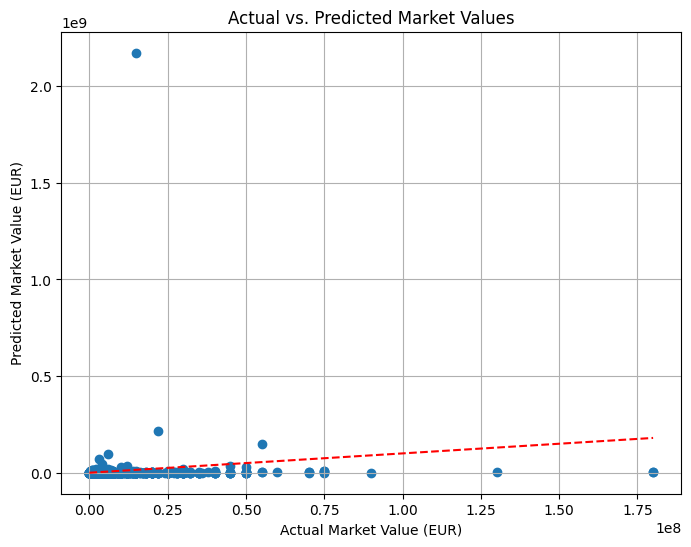

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.scatter(y_true, y_pred, alpha=0.5)
plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--')  # ideal line
plt.xlabel("Actual Market Value (EUR)")
plt.ylabel("Predicted Market Value (EUR)")
plt.title("Actual vs. Predicted Market Values")
plt.grid(True)
plt.show()
